In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# DEVICE의 출력으로 cuda가 나오는지 확인합니다.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE :', DEVICE)

DEVICE : cuda


In [4]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# MNIST dataset을 준비합니다. 필요시 다운로드 받습니다.
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
print(train_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
# MNIST dataset을 트레이닝과 테스트에 사용할 수 있도록 Data Loader를 만듭니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
print('done')

done


In [6]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU())
    def forward(self, x):
        y = self.conv(x)
        return y

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, kernel_size=3):
        super().__init__()
        self.in_layer = Conv2d(in_channels, hidden_channels, 1)
        self.encoder = nn.Sequential(Conv2d(hidden_channels, hidden_channels, kernel_size, stride=2, padding=kernel_size//2),
                                     Conv2d(hidden_channels, hidden_channels, kernel_size, stride=2, padding=kernel_size//2),
                                    )
        self.out_layer = nn.Conv2d(hidden_channels, out_channels, 1)
        
    def forward(self, x):
        y = self.in_layer(x)
        y = self.encoder(y)
        y = self.out_layer(y)
        return y
        

In [8]:
class ConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU())
    def forward(self, x):
        y = self.conv(x)
        return y

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, kernel_size=3):
        super().__init__()
        self.in_layer = Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.encoder = nn.Sequential(ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, stride=2, padding=kernel_size//2-1),
                                     ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, stride=2, padding=kernel_size//2-1),
                                    )
        self.out_layer = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        y = self.in_layer(x)
        y = self.encoder(y)
        y = self.out_layer(y)
        return y
        

In [10]:
class VectorQuantizer(nn.Module):
    def __init__(self, n_codebook, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.n_codebook = n_codebook
        self.embedding = nn.Embedding(n_codebook, z_dim)
        
    def forward(self, z):
        # z : (batch, channels, width, height)
        # (b, w, h, c)
        z = z.permute(0, 2, 3, 1).contiguous()
        # (b*w*h, c)
        z_flat = z.view(-1, z.shape[-1])
        # (b*w*h, n_codebook)
        distances = (z_flat**2).sum(dim=1, keepdim=True) +\
                    (self.embedding.weight**2).sum(dim=1) -\
                    2*z_flat@self.embedding.weight.T
        
        # (b*w*h, 1)
        zq_indexes = distances.argmin(dim=1).unsqueeze(dim=1)
        # (b, n_codebook)
        zq_matrix = torch.zeros(zq_indexes.shape[0], self.n_codebook, device=z.device) 
        zq_matrix.scatter_(1, zq_indexes, 1)
        
        # (b, w, h, c)
        zq = (zq_matrix @ self.embedding.weight).view(z.shape)
        codebook_loss = F.mse_loss(zq, z.detach())
        commitment_loss = F.mse_loss(zq.detach(), z)
        zq = z + (zq - z).detach()
        outputs = {'zq': zq.permute(0, 3, 1, 2).contiguous(),
                   'zq_indexes': zq_indexes.reshape(z.shape[0], z.shape[1], z.shape[2]),
                   'codebook_loss': codebook_loss,
                   'commitment_loss': commitment_loss}
        return outputs

In [11]:
class Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, z_channels, num_embeddings, out_channels,
                 encoder_kernel_size=3, decoder_kernel_size=4):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_channels, z_channels, encoder_kernel_size)
        self.vq = VectorQuantizer(num_embeddings, z_channels)
        self.decoder = Decoder(z_channels, hidden_channels, out_channels, decoder_kernel_size)
        
    def forward(self, x):
        ze = self.encoder(x)
        vq_outputs = self.vq(ze)
        y = self.decoder(vq_outputs['zq'])
        outputs = {'y': y,
                   'ze': ze,
                   'zq_indexes': vq_outputs['zq_indexes'],
                   'codebook_loss': vq_outputs['codebook_loss'],
                   'commitment_loss': vq_outputs['commitment_loss']}
        return outputs

In [12]:
model = Model(in_channels=1, hidden_channels=64, z_channels=2, num_embeddings=64, out_channels=1).cuda()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
print('done')

done


Quantized z vector indexes
[[63 63 63 63 63 63 63]
 [63 63 55 24  7 56 55]
 [63 63 60 23 59  1  9]
 [63 63 18 22 12 11 55]
 [63 63  1 16 23  9 63]
 [63 63 52 23 25 55 63]
 [63 63 38  4 38 55 63]]


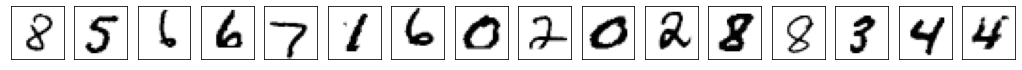

KeyboardInterrupt: ignored

In [14]:
from IPython import display

# Backpropagation이 되도록 준비합니다.
step = 0
while(True):
    for batch_index, batch in enumerate(train_loader):
        # x : image (B, 1, 28, 28,)
        # t : class (B)
        x, t = batch       
        x = x.cuda()
       
        model.train()    
        model.zero_grad()
        outputs = model(x)
        reconstruction_loss = nn.BCEWithLogitsLoss()(outputs['y'], x)
        loss = reconstruction_loss + outputs['codebook_loss'] + 0.25 * outputs['commitment_loss'] 
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(step, loss.item())
        
        if step % 1000 == 0:
            display.clear_output()
            
            print('Quantized z vector indexes')
            print(outputs['zq_indexes'][0].data.cpu().numpy())
            
            _x = x.data.cpu().numpy()
            _y = torch.sigmoid(outputs['y']).data.cpu().numpy()
            
            plt.figure(figsize=[18, 3])
            plt.title('Original')
            for i in range(16):
                plt.subplot(1, 16, i+1)
                plt.imshow(_x[i, 0], cmap='Greys')
                plt.xticks([])
                plt.yticks([])
            plt.show()
            
            plt.figure(figsize=[18, 3])
            plt.title('Reconstructed')
            for i in range(16):
                plt.subplot(1, 16, i+1)
                plt.imshow(_y[i, 0], cmap='Greys')
                plt.xticks([])
                plt.yticks([])
            plt.show()
                
            _weight = model.vq.embedding.weight.data.cpu().numpy()
            _ze = outputs['ze'].permute(0, 2, 3, 1).reshape(-1, 2).data.cpu().numpy()

            plt.title('Codebook and Embeddings')
            plt.scatter(_weight[:, 0], _weight[:, 1], marker='x', label='Codebook')
            plt.scatter(_ze[:, 0], _ze[:, 1], alpha=0.5, label='Embeddings')
            plt.legend()
            plt.show()
        
        step += 1